In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from math import *
import numpy as np
import h5py

from OpticalBeam import *

In [2]:
help(SingleFrequencyBeam)

Help on class SingleFrequencyBeam in module OpticalBeam:

class SingleFrequencyBeam(builtins.object)
 |  SingleFrequencyBeam(f, nx, ny, dx, dy)
 |  
 |  Methods defined here:
 |  
 |  FitSizeW(self, order=4, threshold=-3)
 |      Fit a gaussian profile to the beam and return its size.
 |      @return wx(horizontal pol.), wy(horizontal pol.), wx(vertical pol.), wy(vertical pol.)
 |      
 |      Fitting the logarithmic intensity can be performed to higher oder (default=4)
 |      to reduce the influence of non-gaussian fractions of the beam to the evaluated second-oder coefficient.
 |      All intensity below a certain threshold (default=exp(-3)=0.05) relative to the peak amplitude
 |      will be ignored in te fit.
 |  
 |  Projection(self, polarization='xi', axis='x')
 |      Create an intensity profile along the given axis for the given polarization direction.
 |      The absolute value of the intensity is summed along the other axis.
 |      return position, intensity
 |  
 |  __ini

# Single-Frequency content of the radiation field
# recorded on a screen in a TEUFEL run

### Get the file name:
Instead of using a fixed path string one can use a Tk dialog
to browse for the file to be read.

In [2]:
radfile = "/home/lehnertu/Programming/teufel/elbe-u300_screen_5m.h5"

In [6]:
from tkinter import Tk
from tkinter import filedialog

Tk().withdraw()
radfile = filedialog.askopenfilenames()[0]
print(radfile)

/home/lehnertu/Programming/teufel/elbe-u300_screen_10m.h5


### Read the file and report the geometry:

In [3]:
hdf = h5py.File(radfile, "r")
# Get the groups
pos = hdf['ObservationPosition']
Nx = pos.attrs.get('Nx')
Ny = pos.attrs.get('Ny')
print("Nx=%d Ny=%d" % (Nx,Ny))
print(pos)
field = hdf['ElMagField']
print(field)
t0 = field.attrs.get('t0')
dt = field.attrs.get('dt')
nots = field.attrs.get('NOTS')
print("t0=%g dt=%g NOTS=%d" % (t0, dt, nots))
pos = np.array(pos)
a = np.array(field)
hdf.close()

Nx=64 Ny=64
<HDF5 dataset "ObservationPosition": shape (64, 64, 3), type "<f8">
<HDF5 dataset "ElMagField": shape (64, 64, 1000, 6), type "<f8">
t0=2.33495e-08 dt=1e-13 NOTS=1000


In [4]:
center = (pos[0,0]+pos[Nx-1,0]+pos[0,Ny-1]+pos[Nx-1,Ny-1]) / 4.0
print("center = ", center, " m")
# delta_x and delta_y are vectors
delta_x = (pos[Nx-1,Ny//2] - pos[0,Ny//2]) / (Nx-1)
delta_y = (pos[Nx//2,Ny-1] - pos[Nx//2,0]) / (Ny-1)
# the pixel spacing
dx = sqrt(np.sum(np.square(delta_x)))
dy = sqrt(np.sum(np.square(delta_y)))
print("pixel spacing = (%.2f, %.2f) mm" % (1e3*dx,1e3*dy))
# unit vectors
e_x = delta_x / dx
e_y = delta_y / dy
if np.abs(np.dot(e_x,e_y)) > 1e-4:
    print("WARNING : e_x and e_y are not orthogonal")
    print(e_x)
    print(e_y)
# screen normal vector
normal = np.cross(delta_x,delta_y)
normal = normal / sqrt(np.sum(np.square(normal)))
print("normal = ", normal)

center =  [-5.e-03 -5.e-03  7.e+00]  m
pixel spacing = (10.00, 10.00) mm
normal =  [0. 0. 1.]


## Create a plot of amplitude and phase at a given frequency

The frequency is coaxed to the nearest frequency in the FFT raster of the given data.<br>
The two polarization directions are taken as the alignment vectors of the screen.<br>
Longitudinal fields are neglected.<br>
Only the amplitude of the E field is considered because the
B fields should be linked to E by Maxwells equations.<br>
The plots show amplitude and phase of both polarization directions. The amplitudes are linked to the same scale.

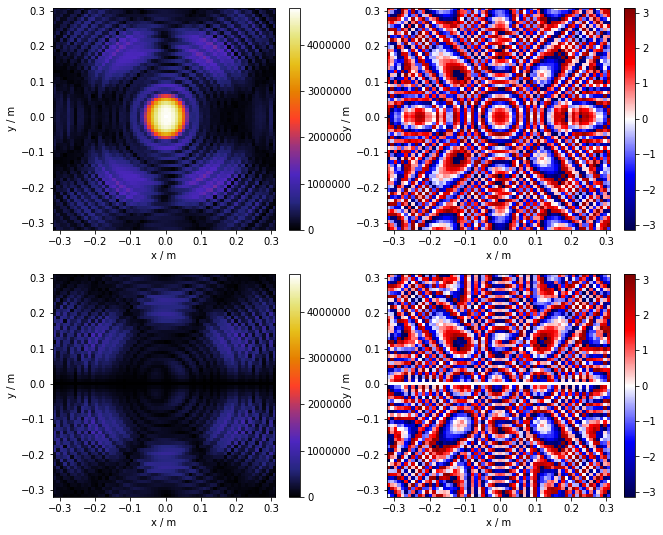

In [5]:
# the frequency for which to create the optical beam
frequency = 1.0e12
# index in the fourier spectrum
f_index = int(round(frequency*dt*nots))
beam = SingleFrequencyBeam(frequency, Nx, Ny, dx, dy)

M = np.zeros((Nx,Ny),dtype=np.cdouble)
for ix in range(Nx):
    for iy in range(Ny):
        trace = a[ix][iy]
        data = trace.transpose()
        Ex = data[0]
        Ey = data[1]
        Ez = data[2]
        EVec = np.array([Ex, Ey, Ez]).transpose()
        E_xi = np.dot(EVec,e_x)
        spect = np.fft.fft(E_xi)
        M[ix,iy] = spect[f_index]
beam.A_xi = ReorderBeamMatrix(M)

M = np.zeros((Nx,Ny),dtype=np.cdouble)
for ix in range(Nx):
    for iy in range(Ny):
        trace = a[ix][iy]
        data = trace.transpose()
        Ex = data[0]
        Ey = data[1]
        Ez = data[2]
        EVec = np.array([Ex, Ey, Ez]).transpose()
        E_eta = np.dot(EVec,e_y)
        spect = np.fft.fft(E_eta)
        M[ix,iy] = spect[f_index]
beam.A_eta = ReorderBeamMatrix(M)

beam.plot()
plt.show()

In [6]:
print(beam.FitSizeW(order=2))
print(beam.FitSizeW(order=4))
print(beam.FitSizeW(order=6))
print(beam.FitSizeW(order=8))
print(beam.FitSizeW(order=10))
print(beam.FitSizeW(order=12))
print(beam.FitSizeW(order=20))

(0.3513787516861559, 0.4903912660284729, 0.0, 0.5247715656652728)
(0.25200296741307826, 0.0, 0.0, 0.0)
(0.1831911018376142, 0.30603017779704234, 0.0, 0.0)
(0.11722709844212618, 0.1102910661052316, 0.0, 0.0)
(0.07909695441554687, 0.06976946361207888, 0.1915301991519764, 0.0)
(0.0, 0.0, 0.0, 0.0)
(620524.473684087, 456332.74225200305, 1260265.360503317, 1321709.5784862111)


(-3, 0)

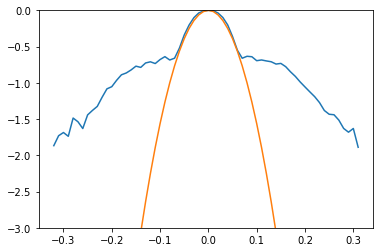

In [19]:
pos, amp = beam.Projection(polarization='xi', axis='x')
amp = np.log(amp)
amp = amp - np.max(amp)
w = 0.08
gauss = -1.0/(w*w)*np.power(pos,2)
plt.plot(pos,amp)
plt.plot(pos,gauss)
plt.ylim(-3,0)

(-3, 0)

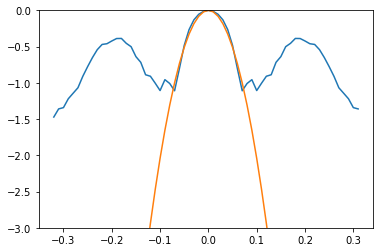

In [21]:
pos, amp = beam.Projection(polarization='xi', axis='y')
amp = np.log(amp)
amp = amp - np.max(amp)
w = 0.07
gauss = -1.0/(w*w)*np.power(pos,2)
plt.plot(pos,amp)
plt.plot(pos,gauss)
plt.ylim(-3,0)

In [9]:
print(beam.FitSizeW(order=2, threshold=-1.5))
print(beam.FitSizeW(order=4, threshold=-1.5))
print(beam.FitSizeW(order=6, threshold=-1.5))
print(beam.FitSizeW(order=8, threshold=-1.5))

(0.2692282449738282, 0.23645009881054502, 0.0, 0.5848941249978896)
(0.14322096657023933, 0.1417550021770221, 0.0, 0.0)
(0.06796763547833154, 0.0765667368756699, 0.0, 0.0)
(0.05218240063262086, 0.057225228385966304, 0.0, 0.0)


-7.009220624729009 0.0
[ 0.00000000e+00  2.54080164e-03  3.78592387e-16 -4.87513671e-03
  1.35040075e-18 -4.97649090e-03 -1.85888958e-05 -1.08339690e-18
  2.69253701e-06 -1.16093425e-21  2.79217487e-07 -6.68023142e-21
  1.58249724e-05  6.27848750e-20  4.73035430e-06]
0.14322096657023933 0.1417550021770221


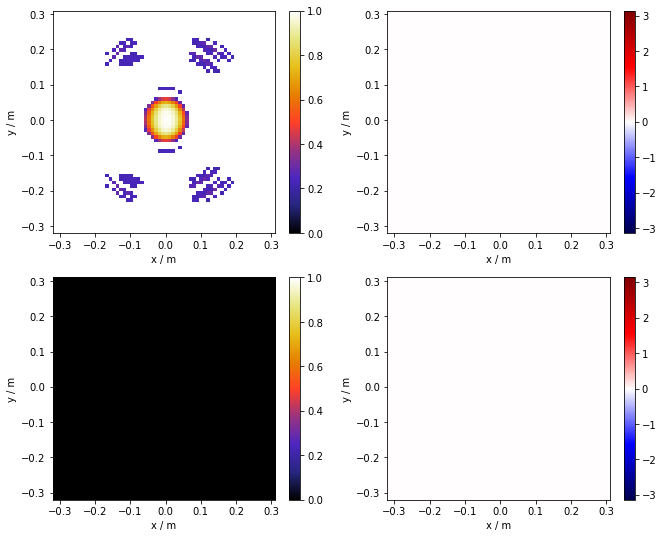

In [10]:
ampl = np.log(np.abs(ReorderBeamMatrix(beam.A_xi)+1e-9).reshape(beam.nx*beam.ny))
ampl = ampl - np.max(ampl)
print(np.min(ampl),np.max(ampl))
threshold = -1.5
weights = np.ones_like(ampl)
weights[ampl<threshold]=0.0
# weights = ampl.copy()
# weights[weights>threshold]=1.0
# weights[weights<=threshold]=0.0
# print(weights)

ix1 = np.arange(beam.nx)-(beam.nx//2)
iy1 = np.arange(beam.ny)-(beam.ny//2)
x, y = np.meshgrid(ix1, iy1)
X = np.array([x,y]).transpose().reshape(beam.nx*beam.ny,2)
# we fit to a very high order so intensity at outer fringes has less influence
# on the second order we are interested in
poly = PolynomialFeatures(degree=4)
X_ = poly.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X_, ampl, sample_weight=weights)
print(clf.coef_)
wx_xi = 1.0/sqrt(-clf.coef_[3]) * beam.dx if clf.coef_[3]<=0 else 0.0
wy_xi = 1.0/sqrt(-clf.coef_[5]) * beam.dy if clf.coef_[5]<=0 else 0.0
print(wx_xi, wy_xi)

beam.A_xi = np.exp(ReorderBeamMatrix((ampl*weights).reshape(beam.nx,beam.ny)))
beam.A_eta = np.zeros((beam.nx,beam.ny))
beam.plot()
plt.show()

## plot a Gaussian beam as reference

In [6]:
help(SingleFrequencyBeam.GaussianBeam)

Help on method GaussianBeam in module OpticalBeam:

GaussianBeam(f, nx, ny, dx, dy, zR, z) method of builtins.type instance
    Create a gaussian beam with width Rayleigh range zR
    at a distance z from the waist (both polarization directions are equal).
    z cannot be exactly zero.



λ = 0.299792 mm
k = 20958.450220 m⁻¹
w0 = 8.173055 mm
w = 58.950616 mm
R = 5.098196 m
(0.08579119850637548, 0.08579119850637548, 0.08579119850637548, 0.08579119850637548)


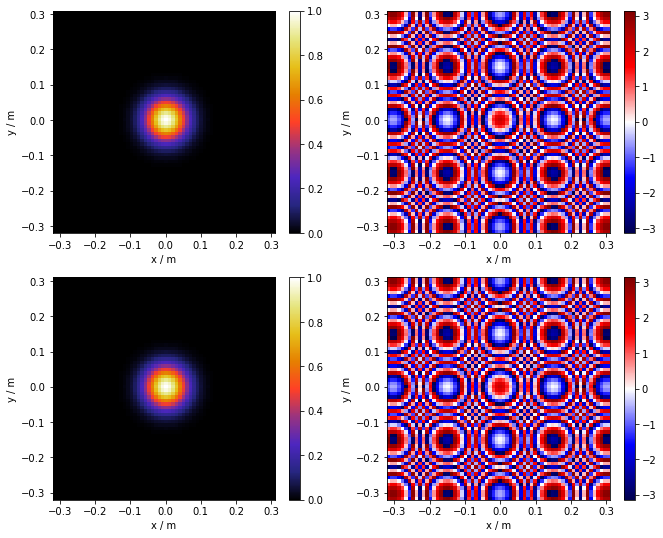

In [9]:
gb = SingleFrequencyBeam.GaussianBeam(frequency, Nx, Ny, dx, dy, 0.7, 5.0002)
print(gb.FitSizeW())
gb.plot()
plt.show()

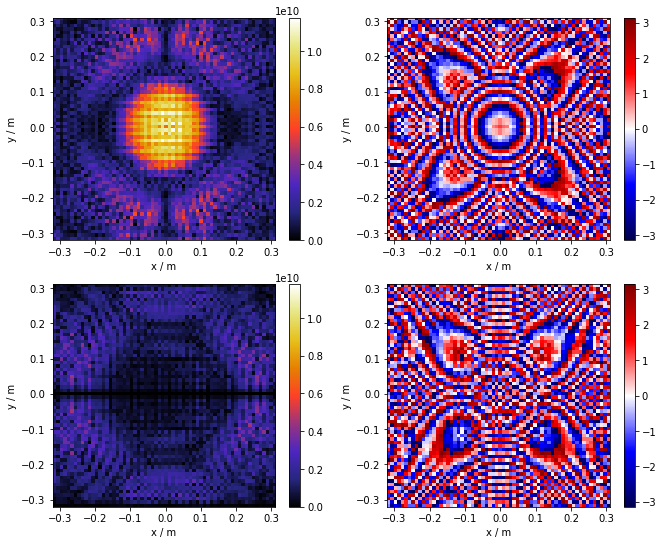

In [7]:
propagated = SingleFrequencyBeam.NearFieldProp(beam,5.0)
propagated.plot()
plt.show()

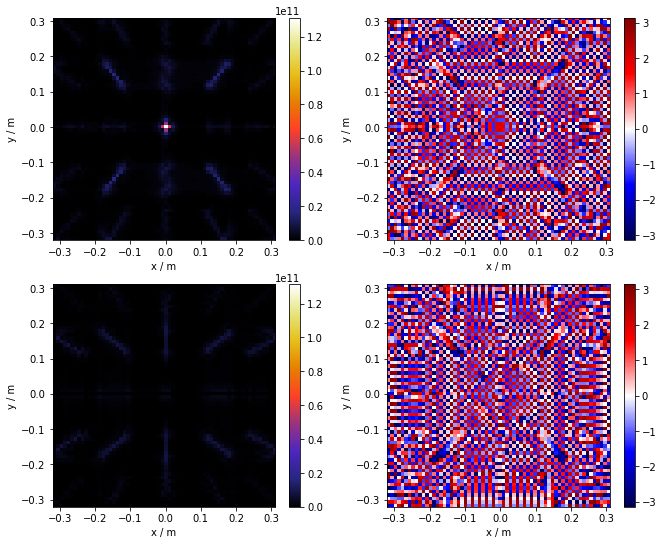

In [15]:
propagated = SingleFrequencyBeam.NearFieldProp(beam,-5.0)
propagated.plot()
plt.show()